In [835]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('ggplot')

In [836]:
LEASE = 3000
get_timestamp = lambda time_str: datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S').timestamp()

In [837]:
def process_complete_leases(work_dir):
    completed_lease = pd.read_csv('%s/complete_leases.csv' % work_dir)
    start_time = completed_lease[completed_lease['completed']==0]['Time'].iloc[0]
    end_time = completed_lease[completed_lease['completed']==LEASE]['Time'].iloc[0]
    return start_time, end_time

In [838]:
def process_osg_jobs(work_dir, end_time):
    osg_jobs = pd.read_csv('%s/osg_jobs.csv' % work_dir)
    osg_jobs = osg_jobs.dropna()
    osg_jobs = osg_jobs[osg_jobs['action'] == 'stop']
    osg_jobs = osg_jobs[osg_jobs['JobSimCompleteDate'] < get_timestamp(end_time)]
    del osg_jobs['_id']
    osg_jobs = osg_jobs[(osg_jobs['TotalCost'] > 0) & (osg_jobs['WastedCost'] >= 0)]
    return osg_jobs

In [839]:
def process_utilization_rate(work_dir, end_time):
    ru = pd.read_csv('%s/utilization_rate.csv' % work_dir)
    ru['Time'] = pd.to_datetime(ru['Time'])
    ru = ru[ru['Time'] <= end_time]
    ru = ru[ru['Chameleon Utl Rate'] != 0]
    ru.set_index(['Time'], inplace=True)
    return ru

In [840]:
def process_node_terminations(work_dir, end_time):
    node_term = pd.read_csv('%s/node_terminations.csv' % work_dir)
    node_term['Time'] = pd.to_datetime(node_term['Time'])
    node_term = node_term[node_term['Time'] <= end_time]
    node_term.dropna(inplace=True)
    node_term.set_index(['Time'], inplace=True)
    return node_term

In [841]:
def count_completed_jobs(osg_jobs):
    return osg_jobs.shape[0]

In [842]:
def get_wasted_cost(osg_jobs):
    return osg_jobs['WastedCost'].sum()

In [843]:
def get_total_utl_rate(utl_rate):
    return utl_rate['Total Util Rate'].quantile(0.25)

In [844]:
def get_in_advance_node_terms(node_term):
    return node_term["success termination"].max()

In [845]:
def get_unused_node_terms(node_term):
    return node_term["unused terminations"].max()

In [846]:
def get_immediate_node_terms(node_term):
    return node_term["immediate termination"].max()

In [847]:
def show_metrics(osg_jobs, utl_rate, node_term):
    print('total_complete_jobs: %d ' % count_completed_jobs(osg_jobs))
    print('wasted_core_hours: %.2f' % get_wasted_cost(osg_jobs))
    print('total_utilization_rate: %.2f' % get_total_utl_rate(utl_rate))
    print('in_advance_node_terms: %d' % get_in_advance_node_terms(node_term))
    print('unused_advance_node_terms: %d' % get_unused_node_terms(node_term))
    print('immediate_node_terms: %d' % get_immediate_node_terms(node_term))

# Baseline

In [848]:
work_dir = 'baseline'
start_time, end_time = process_complete_leases(work_dir)
utl_rate = process_utilization_rate(work_dir, end_time)
# print('total_utilization_rate: %.2f' % get_total_utl_rate(utl_rate))
utl_rate['Total Util Rate'].describe()

23.230584551148223

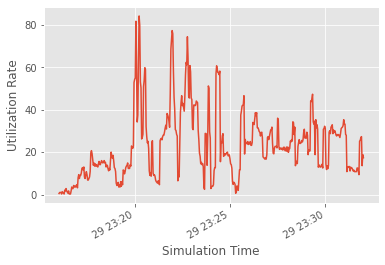

In [849]:
utl_rate['Total Util Rate'].plot()
plt.xlabel('Simulation Time')
plt.ylabel('Utilization Rate')
plt.savefig('utl_rate_baseline.png', dpi=500)

# Baseline With OSG

## random

In [850]:
work_dir = 'baseline-osg/random'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 60044 
wasted_core_hours: 20826.16
total_utilization_rate: 99.30
in_advance_node_terms: 0
unused_advance_node_terms: 0
immediate_node_terms: 2986


## lease_core

In [851]:
work_dir = 'baseline-osg/least_core'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 45744 
wasted_core_hours: 20072.80
total_utilization_rate: 99.30
in_advance_node_terms: 0
unused_advance_node_terms: 0
immediate_node_terms: 3325


## least_resubmit

In [852]:
work_dir = 'baseline-osg/least_resubmit'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 58559 
wasted_core_hours: 17461.28
total_utilization_rate: 99.30
in_advance_node_terms: 0
unused_advance_node_terms: 0
immediate_node_terms: 2999


## recent_deployed

In [853]:
work_dir = 'baseline-osg/recent_deployed'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 57383 
wasted_core_hours: 14985.72
total_utilization_rate: 99.30
in_advance_node_terms: 0
unused_advance_node_terms: 0
immediate_node_terms: 3096


# Rolling Average

## Random

In [854]:
work_dir = 'rolling_mean/random'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 54984 
wasted_core_hours: 23299.95
total_utilization_rate: 98.27
in_advance_node_terms: 1365
unused_advance_node_terms: 733
immediate_node_terms: 1374


## least_core

In [855]:
work_dir = 'rolling_mean/least_core'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 42933 
wasted_core_hours: 20181.46
total_utilization_rate: 98.60
in_advance_node_terms: 1618
unused_advance_node_terms: 845
immediate_node_terms: 1494


## least_resubmit

In [856]:
work_dir = 'rolling_mean/least_resubmit'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 53753 
wasted_core_hours: 19846.91
total_utilization_rate: 98.60
in_advance_node_terms: 1374
unused_advance_node_terms: 735
immediate_node_terms: 1373


## recent_deployed

In [857]:
work_dir = 'rolling_mean/recent_deployed'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 53560 
wasted_core_hours: 13696.71
total_utilization_rate: 98.57
in_advance_node_terms: 1437
unused_advance_node_terms: 751
immediate_node_terms: 1445


# Rolling Median

## random

In [858]:
work_dir = 'rolling_median/random'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 56624 
wasted_core_hours: 22059.50
total_utilization_rate: 98.90
in_advance_node_terms: 1098
unused_advance_node_terms: 175
immediate_node_terms: 1769


## least_core

In [859]:
work_dir = 'rolling_median/least_core'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 42698 
wasted_core_hours: 21507.44
total_utilization_rate: 99.30
in_advance_node_terms: 1321
unused_advance_node_terms: 202
immediate_node_terms: 1987


## lease_resubmit

In [860]:
work_dir = 'rolling_median/least_resubmit'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 53876 
wasted_core_hours: 19148.23
total_utilization_rate: 98.90
in_advance_node_terms: 1145
unused_advance_node_terms: 182
immediate_node_terms: 1840


## recent_deployed

In [861]:
work_dir = 'rolling_median/recent_deployed'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

# LSTM

## random

In [ ]:
work_dir = 'lstm/random'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 55692 
wasted_core_hours: 24917.75
total_utilization_rate: 97.80
in_advance_node_terms: 1205
unused_advance_node_terms: 1028
immediate_node_terms: 1467


## least_core

In [ ]:
work_dir = 'lstm/least_core'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 43532 
wasted_core_hours: 24600.76
total_utilization_rate: 98.60
in_advance_node_terms: 1432
unused_advance_node_terms: 1131
immediate_node_terms: 1617


## least_resubmit

In [ ]:
work_dir = 'lstm/least_resubmit'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 53240 
wasted_core_hours: 23062.24
total_utilization_rate: 98.20
in_advance_node_terms: 1253
unused_advance_node_terms: 992
immediate_node_terms: 1506


In [ ]:
work_dir = 'lstm/recent_deployed'
start_time, end_time = process_complete_leases(work_dir)
osg_jobs = process_osg_jobs(work_dir, end_time)
utl_rate = process_utilization_rate(work_dir, end_time)
node_term = process_node_terminations(work_dir, end_time)
show_metrics(osg_jobs, utl_rate, node_term)

total_complete_jobs: 53652 
wasted_core_hours: 17597.10
total_utilization_rate: 98.20
in_advance_node_terms: 1277
unused_advance_node_terms: 1057
immediate_node_terms: 1524
